In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
spam_path = "../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv"
df = pd.read_csv(spam_path)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
X = df.Message
Y = df.Category
X.head(3), Y.head(3)

(0    Go until jurong point, crazy.. Available only ...
 1                        Ok lar... Joking wif u oni...
 2    Free entry in 2 a wkly comp to win FA Cup fina...
 Name: Message, dtype: object,
 0     ham
 1     ham
 2    spam
 Name: Category, dtype: object)

In [4]:
whole_text = ''
for i in X:
    whole_text += i + ' '
stop_words = stopwords.words("english")
def clean_text(text):
    text = text.lower()           # converting to lowercase
    text = re.sub("@\S+", " ", text)  
    text = re.sub("https*\S+", " ", text)      #\S - не пробел 
    text = re.sub("www\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)        # remove all numbers
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)     # remove punctuations
    text = re.sub('\n', ' ', text)        
    text = re.sub('\s{2,}',' ', text)        # remove extra spaces
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text
whole_text_clean = clean_text(whole_text)
tokens = word_tokenize(whole_text_clean)
lemmatizer = WordNetLemmatizer()
lemtokens= [lemmatizer.lemmatize(t) for t in tokens]
dictionary = list(set(lemtokens))

In [5]:
def convert(text):
    text = clean_text(text)
    tok = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(t) for t in tok]
    res = [dictionary.index(i) for i in lem]
    return res
X = X.apply(convert)
X.head(3)

0    [7054, 3555, 4778, 2763, 3384, 4411, 2447, 590...
1                  [3547, 4421, 2911, 1563, 4810, 725]
2    [596, 5193, 2937, 3797, 1982, 3918, 1439, 5510...
Name: Message, dtype: object

In [6]:
def encoding(text):
    if text == 'ham':
        return 0
    elif text == 'spam':
        return 1
    else:
        return -1
Y = Y.apply(encoding)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = np.asarray(Y_train).astype("float32")
y_test = np.asarray(Y_test).astype("float32")

In [8]:
maxlen = 50
x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen)
x_train

array([[   0,    0,    0, ..., 2917, 3552, 6983],
       [   0,    0,    0, ..., 5917, 1974,  344],
       [   0,    0,    0, ..., 1393, 4810, 5901],
       ...,
       [   0,    0,    0, ..., 3987, 3626,  680],
       [   0,    0,    0, ..., 2911, 4490, 5901],
       [   0,    0,    0, ..., 3327, 1701, 5543]], dtype=int32)

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [11]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
max_features = 8000
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(20, activation="tanh")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit( x_train, y_train, 
                    batch_size=500, 
                    epochs=10, 
                    validation_split=0.2,
                    validation_data=(x_test, y_test), 
                    shuffle = True,
                    callbacks = my_callbacks )
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

Epoch 1/10
8/8 [==============================] - 4s 239ms/step - loss: 0.5844 - accuracy: 0.7840 - val_loss: 0.5161 - val_accuracy: 0.8576
Epoch 2/10
8/8 [==============================] - 1s 186ms/step - loss: 0.5069 - accuracy: 0.8303 - val_loss: 0.3835 - val_accuracy: 0.8576
Epoch 3/10
8/8 [==============================] - 2s 190ms/step - loss: 0.4393 - accuracy: 0.8468 - val_loss: 0.3501 - val_accuracy: 0.8576
Epoch 4/10
8/8 [==============================] - 2s 191ms/step - loss: 0.3751 - accuracy: 0.8603 - val_loss: 0.3281 - val_accuracy: 0.8576
Epoch 5/10
8/8 [==============================] - 2s 192ms/step - loss: 0.3117 - accuracy: 0.8842 - val_loss: 0.2294 - val_accuracy: 0.8834
Epoch 6/10
8/8 [==============================] - 2s 190ms/step - loss: 0.2275 - accuracy: 0.9181 - val_loss: 0.1676 - val_accuracy: 0.9496
Epoch 7/10
8/8 [==============================] - 2s 220ms/step - loss: 0.1632 - accuracy: 0.9506 - val_loss: 0.1264 - val_accuracy: 0.9596
Epoch 8/10
8/8 [====

In [12]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.06664438545703888
Test accuracy: 0.9802690744400024


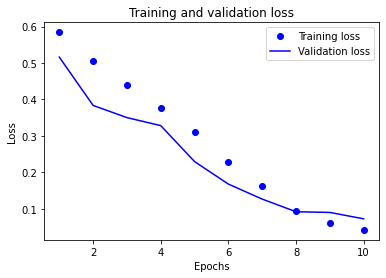

In [13]:
history_dict = history.history
history_dict.keys()
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()